In [1]:
import pandas as pd 
import numpy as np
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
current_directory = os.getcwd()
print(current_directory)


C:\Users\saries


In [3]:
os.chdir('C:/Users/saries/Desktop/F3 Project')

tmp_all = pd.read_csv('cimis_all_stations.csv.gz')

In [4]:
tmp_all.head()

,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),qc,Precip (mm),qc.1,...,Rel Hum (%),qc.5,Dew Point (C),qc.6,Wind Speed (m/s),qc.7,Wind Dir (0-360),qc.8,Soil Temp (C),qc.9
0,105,Westlands,San Joaquin Valley,9/28/2010,100,271,0.06,,0.0,,...,35.0,,4.7,,1.7,,253.0,,22.8,
1,105,Westlands,San Joaquin Valley,9/28/2010,200,271,0.05,,0.0,,...,38.0,,5.3,,1.8,,95.0,,22.5,
2,105,Westlands,San Joaquin Valley,9/28/2010,300,271,0.04,,0.0,,...,42.0,,5.9,,1.3,,141.0,,22.2,
3,105,Westlands,San Joaquin Valley,9/28/2010,400,271,0.03,,0.0,,...,41.0,,5.2,,1.0,,186.0,,21.9,
4,105,Westlands,San Joaquin Valley,9/28/2010,500,271,0.04,,0.0,,...,40.0,,2.8,,1.4,,254.0,,21.6,


In [5]:
tmp_all['Date'] = pd.to_datetime(tmp_all['Date'], format='%m/%d/%Y')

tmp_all['Month'] = tmp_all['Date'].dt.month
tmp_all['Year'] = tmp_all['Date'].dt.year
tmp_all['Day'] = tmp_all['Date'].dt.day

In [6]:
tmp_all.head()

,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),qc,Precip (mm),qc.1,...,qc.6,Wind Speed (m/s),qc.7,Wind Dir (0-360),qc.8,Soil Temp (C),qc.9,Month,Year,Day
0,105,Westlands,San Joaquin Valley,2010-09-28,100,271,0.06,,0.0,,...,,1.7,,253.0,,22.8,,9,2010,28
1,105,Westlands,San Joaquin Valley,2010-09-28,200,271,0.05,,0.0,,...,,1.8,,95.0,,22.5,,9,2010,28
2,105,Westlands,San Joaquin Valley,2010-09-28,300,271,0.04,,0.0,,...,,1.3,,141.0,,22.2,,9,2010,28
3,105,Westlands,San Joaquin Valley,2010-09-28,400,271,0.03,,0.0,,...,,1.0,,186.0,,21.9,,9,2010,28
4,105,Westlands,San Joaquin Valley,2010-09-28,500,271,0.04,,0.0,,...,,1.4,,254.0,,21.6,,9,2010,28


In [7]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

tmp_all['Season'] = tmp_all['Month'].apply(get_season)

In [8]:
print(tmp_all[['Date', 'Month', 'Year', 'Season']].head())

        Date  Month  Year Season
0 2010-09-28      9  2010   Fall
1 2010-09-28      9  2010   Fall
2 2010-09-28      9  2010   Fall
3 2010-09-28      9  2010   Fall
4 2010-09-28      9  2010   Fall


In [9]:
points = pd.read_csv('2-fivepoints.csv')

In [10]:
points.columns

Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date', 'Hour (PST)', 'Jul',
       'ETo (mm)', 'qc', 'Precip (mm)', 'qc.1', 'Sol Rad (W/sq.m)', 'qc.2',
       'Vap Pres (kPa)', 'qc.3', 'Air Temp (C)', 'qc.4', 'Rel Hum (%)', 'qc.5',
       'Dew Point (C)', 'qc.6', 'Wind Speed (m/s)', 'qc.7', 'Wind Dir (0-360)',
       'qc.8', 'Soil Temp (C)', 'qc.9'],
      dtype='object')

In [11]:
tmp_all.columns

Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date', 'Hour (PST)', 'Jul',
       'ETo (mm)', 'qc', 'Precip (mm)', 'qc.1', 'Sol Rad (W/sq.m)', 'qc.2',
       'Vap Pres (kPa)', 'qc.3', 'Air Temp (C)', 'qc.4', 'Rel Hum (%)', 'qc.5',
       'Dew Point (C)', 'qc.6', 'Wind Speed (m/s)', 'qc.7', 'Wind Dir (0-360)',
       'qc.8', 'Soil Temp (C)', 'qc.9', 'Month', 'Year', 'Day', 'Season'],
      dtype='object')

In [12]:
tmp_all["frost_event"] = (tmp_all["Air Temp (C)"] < 0).astype(int)

for h in [3, 6, 12, 24]:

    tmp_all[f"temp_{h}h_ahead"] = (
        tmp_all.groupby("Stn Id")["Air Temp (C)"].shift(-h)
    )

    tmp_all[f"frost_{h}h_ahead"] = (
        tmp_all[f"temp_{h}h_ahead"] < 0
    ).astype(int)

Since the challenge asks us to predict frost risk (T < 0 °C) and expected temperature at 3 h, 6 h, 12 h, 24 h horizons, we will create columns for these.

"In addition, the dew point temperature is often used to predict the next morning’s minimum temperature.  Consequently, it is extremely important for freeze protection of crops."

https://biomet.ucdavis.edu/doc/Principles_of_Frost_Protection%E2%80%93UCDavis_Biometeorology_Group.ptmp_all on Page 7

In [13]:
for h in [1, 3, 6, 12]:

    grp = tmp_all.groupby("Stn Id")  # group once for efficiency

    # Temperature lag and change
    lag_temp = grp["Air Temp (C)"].shift(h)
    tmp_all[f"temp_lag_{h}h"] = lag_temp
    tmp_all[f"temp_change_{h}h"] = tmp_all["Air Temp (C)"] - lag_temp

    # Dewpoint depression lag
    tmp_all[f"dewpoint_dep_{h}h"] = (
        grp["Air Temp (C)"].shift(h) - grp["Dew Point (C)"].shift(h)
    )

    # Humidity lag
    tmp_all[f"hum_lag_{h}h"] = grp["Rel Hum (%)"].shift(h)

    # Wind lag
    tmp_all[f"wind_lag_{h}h"] = grp["Wind Speed (m/s)"].shift(h)

"The dew point is important in meteorology because it is directly related to the amount of water vapor in the air and it can be used to determine other variables (e.g., vapor pressure, relative humidity, wet bulb temperature, and vapor pressure deficit) that are often used in agriculture." Page 7 

Dewpoint depression is simply measuring the difference between the air temperature and dew point temperature. A small dewpoint depression means that the air is close to saturation and when the dewpoint is high realtive to the air temperature, the air cannot hold much more moisture. This allows for rapid radiative cooling due to the difference in temperature.

This video exlains the mechanism a little bit: https://youtu.be/6buQuGG53gs?si=GKY9xD4dmnzo_kOB&t=11.

Temperature Change / Cooling Rate (Air Temp – Air Temp.shift(3) : 
This is simply how fast the surface layer is cooling during the evening. This is important since rapid cooling after sunset is a strong precursor to frost formation.

Calm-Wind Indicator (Wind Speed < 1 m/s) :
This is an important predictor because calm winds allow cold, dense air to settle near the surface. Most radiation frosts occur under clear, calm conditions because minimal turbulence prevents mixing with warmer air aloft. When wind speed drops below 1 m/s, surface cooling accelerates and frost risk increases significantly.

Vapor Pressure Deficit (VPD) : Represents atmospheric dryness. Low VPD indicates moist air and slower cooling, while high VPD indicates dry air and faster radiational cooling. Sudden decreases in VPD often precede frost formation. Is calculated using "Saturation vapor pressure" (es), which represents the maximum moisture the air could hold at a given temperature. Subtracting the actual vapor pressure gives VPD, which measures atmospheric dryness.

In [14]:
tmp_all["dewpoint_dep"] = tmp_all["Air Temp (C)"] - tmp_all["Dew Point (C)"]
tmp_all["temp_rate"] = tmp_all["Air Temp (C)"] - tmp_all["Air Temp (C)"].shift(3)
tmp_all["calm_wind"] = (tmp_all["Wind Speed (m/s)"] < 1).astype(int)
es = 0.6108 * np.exp((17.27 * tmp_all["Air Temp (C)"]) / (tmp_all["Air Temp (C)"] + 237.3))
tmp_all["vpd"] = es - tmp_all["Vap Pres (kPa)"]

We encode the month using sine and cosine so the model understands that months are cyclical. Without this transformation, the model would treat December (12) and January (1) as being far apart, even though they are consecutive and belong to the same season. The sine/cosine encoding fixes this by placing all months on a circular scale, preserving their seasonal relationships.

In [15]:
tmp_all["is_night"] = (tmp_all["Sol Rad (W/sq.m)"] < 10).astype(int)


tmp_all["month_sin"] = np.sin(2 * np.pi * tmp_all["Month"] / 12)
tmp_all["month_cos"] = np.cos(2 * np.pi * tmp_all["Month"] / 12)

We will now apply the same logic to the direction, because right now the wind direction being 359° and 1° are being perceived to be much different than we know them to be in reality.

In [16]:
rad = np.deg2rad(tmp_all["Wind Dir (0-360)"])
tmp_all["wind_u"] = tmp_all["Wind Speed (m/s)"] * np.cos(rad)  # east–west
tmp_all["wind_v"] = tmp_all["Wind Speed (m/s)"] * np.sin(rad)  # north–south

In [17]:
station_meta = tmp_all[["Stn Id","Stn Name","CIMIS Region"]].drop_duplicates().reset_index(drop=True)

tmp_all = tmp_all.merge(station_meta, on=["Stn Id","Stn Name","CIMIS Region"], how="left")

In [18]:
tmp_all.head()

,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),qc,Precip (mm),qc.1,...,wind_lag_12h,dewpoint_dep,temp_rate,calm_wind,vpd,is_night,month_sin,month_cos,wind_u,wind_v
0,105,Westlands,San Joaquin Valley,2010-09-28,100,271,0.06,,0.0,,...,NaN,15.9,NaN,0,1.526552,1,-1.0,-1.836970e-16,-0.497032,-1.625718
1,105,Westlands,San Joaquin Valley,2010-09-28,200,271,0.05,,0.0,,...,NaN,14.7,NaN,0,1.438281,1,-1.0,-1.836970e-16,-0.156880,1.793150
2,105,Westlands,San Joaquin Valley,2010-09-28,300,271,0.04,,0.0,,...,NaN,13.1,NaN,0,1.297393,1,-1.0,-1.836970e-16,-1.010290,0.818117
3,105,Westlands,San Joaquin Valley,2010-09-28,400,271,0.03,,0.0,,...,NaN,13.6,-1.8,0,1.270125,1,-1.0,-1.836970e-16,-0.994522,-0.104528
4,105,Westlands,San Joaquin Valley,2010-09-28,500,271,0.04,,0.0,,...,NaN,13.8,-3.4,0,1.189152,1,-1.0,-1.836970e-16,-0.385892,-1.345766


In [19]:
import re

target = "frost_6h_ahead"
group_col = "Stn Id"

qc_cols = [c for c in tmp_all.columns if str(c).startswith("qc")]

future_cols = [c for c in tmp_all.columns
               if re.match(r"^(temp|frost)_\d+h_ahead$", str(c))]

exclude = set(
    [target, group_col, "Stn Name", "CIMIS Region", "Date", "Hour (PST)"]
    + qc_cols
    + future_cols        # <- drop ALL future horizon cols
)

num_feats = [c for c in tmp_all.columns
             if c not in exclude and pd.api.types.is_numeric_dtype(tmp_all[c])]

maybe_cat = ["climate_zone"]
cat_feats = [c for c in maybe_cat if c in tmp_all.columns]

used_cols = num_feats + cat_feats

transformers = [
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_feats)
]
if cat_feats:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats))

pre = ColumnTransformer(transformers, remainder="drop")

In [20]:
base_model = XGBClassifier(
    n_estimators=200,        # fewer trees; early stopping trims further
    learning_rate=0.12,     # slightly higher for speed
    max_depth=3,            # shallower trees are faster
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist",     # if you have GPU: use "gpu_hist"
    verbosity=0
)

X_raw = tmp_all[used_cols].copy()

for c in num_feats:
    X_raw[c] = X_raw[c].astype(np.float32)
y = tmp_all[target].astype(int)
groups = tmp_all[group_col]

gkf = GroupKFold(n_splits=tmp_all[group_col].nunique())
scores = []

for fold, (tr, te) in enumerate(gkf.split(X_raw, y, groups=groups), 1):
    Xtr_raw, Xval_raw, ytr, yval = train_test_split(
        X_raw.iloc[tr], y.iloc[tr], test_size=0.10, random_state=42, stratify=y.iloc[tr]
    )
    Xte_raw, yte = X_raw.iloc[te], y.iloc[te]

    pre.fit(Xtr_raw, ytr)
    Xtr  = pre.transform(Xtr_raw)
    Xval = pre.transform(Xval_raw)
    Xte  = pre.transform(Xte_raw)

    model = XGBClassifier(
    n_estimators=120,      # fewer trees
    learning_rate=0.12,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist",
    verbosity=0
)

    model.fit(Xtr, ytr)


    p = model.predict_proba(Xte)[:, 1]
    scores.append(brier_score_loss(yte, p))
    print(f"Fold {fold}: brier={scores[-1]:.4f}", flush=True)


print("LOSO Brier mean ± sd:", np.mean(scores), "±", np.std(scores))


Fold 1: brier=0.0059
Fold 2: brier=0.0046
Fold 3: brier=0.0047
Fold 4: brier=0.0044
Fold 5: brier=0.0060
Fold 6: brier=0.0051
Fold 7: brier=0.0028
Fold 8: brier=0.0039
Fold 9: brier=0.0045
Fold 10: brier=0.0084
Fold 11: brier=0.0048
Fold 12: brier=0.0084
Fold 13: brier=0.0065
Fold 14: brier=0.0025
Fold 15: brier=0.0041
Fold 16: brier=0.0059
Fold 17: brier=0.0042
Fold 18: brier=0.0065
LOSO Brier mean ± sd: 0.0051657828025819036 ± 0.0015681415810543818


In [23]:
mean_frost = y.mean()
baseline_brier = np.mean((mean_frost - y)**2)

print("Frost rate:", y.mean())
print("Baseline Brier:", baseline_brier)
print("Model mean Brier:", np.mean(scores))
print("Improvement:", 1 - np.mean(scores)/baseline_brier)

Frost rate: 0.008579599216004326
Baseline Brier: 0.008505989693297059
Model mean Brier: 0.0051657828025819036
Improvement: 0.39268880061626754


This basically means that if you always predicted a frost probability equal to the historical frost frequency, your baseline Brier score would be 0.0085. In comparison, our model’s Brier score is 39.3% lower, meaning it provides 39.3% better probabilistic accuracy than climatology.

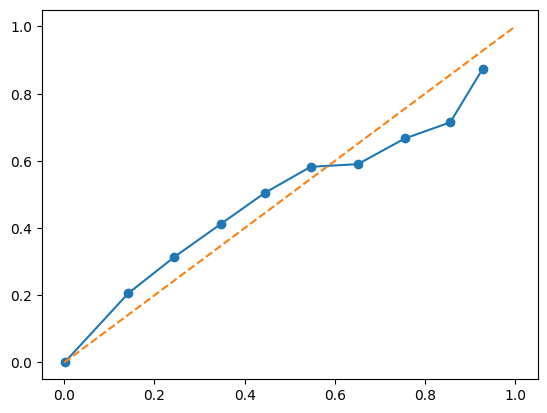

In [24]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
prob_true, prob_pred = calibration_curve(yte, p, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')

In [25]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(yte, p))

ROC-AUC: 0.9935158655558435


Here we will look at the feature importances from the trained XGBoost model using the gain metric. This reveals which predictors contribute most to reducing error across the decision trees, and therefore which variables the model considers most informative for frost forecasting.

In [26]:
model.get_booster().get_score(importance_type='gain')

{'f0': 83.46697998046875,
 'f1': 69.28083801269531,
 'f3': 321.9444885253906,
 'f4': 210.47068786621094,
 'f5': 618.5256958007812,
 'f6': 20.043357849121094,
 'f7': 1157.294677734375,
 'f8': 65.49110412597656,
 'f9': 6.6636505126953125,
 'f10': 598.8933715820312,
 'f11': 44.66310119628906,
 'f12': 108.36712646484375,
 'f13': 30.95562171936035,
 'f15': 2899.831787109375,
 'f16': 168.44659423828125,
 'f17': 84.71440124511719,
 'f18': 76.31112670898438,
 'f19': 21.726959228515625,
 'f20': 69.10191345214844,
 'f21': 70.73120880126953,
 'f22': 70.367919921875,
 'f23': 5.249992370605469,
 'f24': 54.44306182861328,
 'f25': 143.46238708496094,
 'f26': 3247.59619140625,
 'f27': 73.92271423339844,
 'f28': 92.09918975830078,
 'f29': 75.5201644897461,
 'f30': 510.81884765625,
 'f31': 152.6686248779297,
 'f32': 88.49119567871094,
 'f33': 44.752620697021484,
 'f34': 147.8514862060547,
 'f35': 38.010711669921875,
 'f36': 70.27425384521484,
 'f38': 127.352783203125,
 'f39': 127.76765441894531,
 'f41':

In [27]:
feature_names = pre.get_feature_names_out()  # names after ColumnTransformer
booster = model.get_booster()
imp_gain = booster.get_score(importance_type="gain")

mapped = { feature_names[int(k[1:])]: v for k, v in imp_gain.items() }
top = sorted(mapped.items(), key=lambda kv: kv[1], reverse=True)[:25]
for name, gain in top:
    print(f"{name:40s}  gain={gain:.3f}")

num__temp_change_6h                       gain=3247.596
num__temp_lag_1h                          gain=2899.832
num__Dew Point (C)                        gain=1157.295
num__month_cos                            gain=764.150
num__Air Temp (C)                         gain=618.526
num__Soil Temp (C)                        gain=598.893
num__temp_lag_12h                         gain=510.819
num__Sol Rad (W/sq.m)                     gain=321.944
num__Vap Pres (kPa)                       gain=210.471
num__temp_change_1h                       gain=168.447
num__temp_change_12h                      gain=152.669
num__wind_lag_12h                         gain=147.851
num__temp_lag_6h                          gain=143.462
num__is_night                             gain=127.768
num__vpd                                  gain=127.353
num__Year                                 gain=108.367
num__hum_lag_6h                           gain=92.099
num__dewpoint_dep_12h                     gain=88.491
num__dewp

The ROC-AUC being 0.9935 doesn't have anything to do with the probability, but in this case it means that model's ability to rank frost vs. non-frost cases is very strong. This seems pretty likely since frost has a very distinct signature that we have captured (temperature change dropping sharply, dewpoint depression collapses, wind is near-zero, radiation being low, it being nighttime, etc)."